<a href="https://colab.research.google.com/github/mirklys/little-projects/blob/main/crop-yield-prediction/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Crop Yield Prediction

## Pre-setup

In [9]:
!pip install pyspark
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from functools import reduce
import zipfile
import re
from datetime import date

# installing extra packages

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, regexp_replace, when, lit, \
                                  sum, coalesce, udf
from pyspark.sql.types import IntegerType
import rasterio

import warnings
warnings.filterwarnings("ignore")

In [4]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
# this is space for changing to gpu/tpu

In [5]:
drive.mount('/content/gdrive', force_remount=True)
PATH_MAIN = '/content/gdrive/MyDrive/Projects/Crop Yield Prediction'
os.chdir(PATH_MAIN)

Mounted at /content/gdrive


In [7]:
os.getcwd()

'/content/gdrive/MyDrive/Projects/Crop Yield Prediction'

## Loading the data
The data folder contains files with different file extensions; many of the files must be extracted, some are .gz, some are .zip. 

In [ ]:
# Data folder contains: crop-yield, soil-properties, weather data
crop_yield_files = os.listdir('./data/crop-yield')
crop_yield_files = ['./data/crop-yield/' + f for f in crop_yield_files if not f.startswith('./data/crop-yield/')]


crop_yield_dfs = [spark.read.option("header", "true").csv(PATH_MAIN+f[1:]) for f in crop_yield_files]
# concatenate all DataFrames into a single DataFrame
crop_yield_df = reduce(lambda df1, df2: df1.unionAll(df2), crop_yield_dfs)

In [8]:
# https://www.ncei.noaa.gov/pub/data/ghcn/daily/
weather_files = os.listdir('./data/weather')
weather_files = ['./data/weather/' + f for f in weather_files if not f.startswith('./data/weather/')]
weather_dfs = {}

for wf in weather_files:
    if wf[15:19] == '2012' or wf[15:19] == '2017':
        weather_dfs[wf[15:19]] = spark.read \
            .option("header", "false") \
            .option("inferSchema", "true") \
            .option("compression", "gzip") \
            .csv(os.path.join(PATH_MAIN, wf))


weather_dfs = {year: df.withColumn('year', lit(year)) for year, df in weather_dfs.items()}
weather_df = reduce(lambda df1, df2: df1.unionAll(df2), weather_dfs.values())

```
ID = 11 character station identification code
YEAR/MONTH/DAY = 8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)
ELEMENT = 4 character indicator of element type 
DATA VALUE = 5 character data value for ELEMENT 
M-FLAG = 1 character Measurement Flag 
Q-FLAG = 1 character Quality Flag 
S-FLAG = 1 character Source Flag 
OBS-TIME = 4-character time of observation in hour-minute format (i.e. 0700 = 7:00 am)
```

In [10]:
weather_df.show()

+-----------+--------+----+---+----+----+---+----+----+
|        _c0|     _c1| _c2|_c3| _c4| _c5|_c6| _c7|year|
+-----------+--------+----+---+----+----+---+----+----+
|AE000041196|20120101|TMAX|269|null|null|  S|null|2012|
|AE000041196|20120101|TMIN| 96|null|null|  S|null|2012|
|AE000041196|20120101|TAVG|176|   H|null|  S|null|2012|
|AEM00041194|20120101|TMAX|276|null|null|  S|null|2012|
|AEM00041194|20120101|TMIN|154|null|null|  S|null|2012|
|AEM00041194|20120101|PRCP|  0|null|null|  S|null|2012|
|AEM00041194|20120101|TAVG|209|   H|null|  S|null|2012|
|AEM00041217|20120101|TMAX|275|null|null|  S|null|2012|
|AEM00041217|20120101|TMIN|138|null|null|  S|null|2012|
|AEM00041217|20120101|TAVG|198|   H|null|  S|null|2012|
|AEM00041218|20120101|TMAX|265|null|null|  S|null|2012|
|AEM00041218|20120101|TMIN|152|null|null|  S|null|2012|
|AEM00041218|20120101|TAVG|206|   H|null|  S|null|2012|
|AFM00040938|20120101|TAVG| 57|   H|null|  S|null|2012|
|AFM00040948|20120101|TAVG|  2|   H|null|  S|nul

In [ ]:
soil_properties_files = os.listdir('./data/soil-properties')
soil_properties_files = ['./data/soil-properties/' + f for f in soil_properties_files if not f.startswith('./data/soil-properties/')]
soil_properties_df = pd.DataFrame()
with zipfile.ZipFile(soil_properties_files[0], 'r') as zip_ref:
    zip_ref.extractall('./data/soil-properties/data/')
soil_properties_files_data = os.listdir('./data/soil-properties/data')
soil_properties_files_data = ['./data/soil-properties/data/' + f for f in soil_properties_files_data if not f.startswith('./data/soil-properties/data/')]
for spfd in soil_properties_files_data:
    if spfd.endswith('.zip'):
        with zipfile.ZipFile(spfd, 'r') as zip_ref:
            filename = os.path.splitext(os.path.basename(spfd))[0]
            zip_ref.extractall('./data/soil-properties/data/{}/'.format(filename))

In [ ]:
soil_properties_files_data = os.listdir('./data/soil-properties/data')
soil_properties_files_data = ['./data/soil-properties/data/' + f for f in soil_properties_files_data if not f.startswith('./data/soil-properties/data/')]

In [ ]:
soil_porosity_path = './data/soil-properties/data/por_gNATSGO/por_gNATSGO/por_gNATSGO_US.tif'
with rasterio.open(soil_porosity_path) as src:
    soil_porosity_data = src.read(1)
print('Number of bands in the raster:', soil_porosity_data)

## Analyzing Crop Yield

In [ ]:
crop_yield_df = crop_yield_df.drop("Week Ending","Ag District","Ag District Code", 'County',
                   'County ANSI', 'Zip Code', 'Region', 'WaterShed',
                   'Geo Level', 'watershed_code', 'Program', 'Period')
crop_yield_df = crop_yield_df.filter(~col("Data Item").rlike(r"\bSALES\b|\bOPERATIONS\b|\bPRODUCTION\b"))
crop_yield_df = crop_yield_df.withColumn("Value", regexp_replace("Value", "\(H\)|\(D\)", "null"))

In [ ]:
crop_yield_df.show()

+----+--------+----------+------------------+--------------------+--------------+--------------------+------+------+
|Year|   State|State ANSI|         Commodity|           Data Item|        Domain|     Domain Category| Value|CV (%)|
+----+--------+----------+------------------+--------------------+--------------+--------------------+------+------+
|2021| ALABAMA|        01| FIELD CROP TOTALS|FIELD CROP TOTALS...|ORGANIC STATUS|ORGANIC STATUS: (...| 1,270|  85.5|
|2021| ALABAMA|        01|               HAY|HAY, (EXCL ALFALF...|ORGANIC STATUS|ORGANIC STATUS: (...| 1,270|  85.5|
|2021| ALABAMA|        01|               HAY|HAY, ORGANIC - AC...|ORGANIC STATUS|ORGANIC STATUS: (...| 1,270|  85.5|
|2021| ARIZONA|        04|         CHICKPEAS|CHICKPEAS, ORGANI...|ORGANIC STATUS|ORGANIC STATUS: (...|  null|   (D)|
|2021| ARIZONA|        04|            COTTON|COTTON, ORGANIC -...|ORGANIC STATUS|ORGANIC STATUS: (...|  null|   (D)|
|2021| ARIZONA|        04| FIELD CROP TOTALS|FIELD CROP TOTALS..

In [ ]:
crop_total_df = crop_yield_df.filter(col('Commodity')=='FIELD CROP TOTALS')
crop_total_df = crop_total_df.drop('Commodity', 'Data Item', 'Domain',
                                   'Domain Category')

#crop_total_df = crop_total_df.withColumnRenamed("Value", "Total Harvested") \
#       .withColumn("Total Harvested", col("Total Harvested") * 4046.856422)
crop_total_df = crop_total_df.withColumnRenamed("Value", "total_harvested") \
                .withColumn("total_harvested",
                            when(col("total_harvested").rlike("\d+"), 
                                 regexp_replace(col("total_harvested"), ",", "") \
                                 .cast("integer") * 4046.86) \
                                 .otherwise(col("total_harvested")))
crop_total_df = crop_total_df.groupBy("Year", "State").agg(sum("total_harvested").alias("total_harvested"))

In [ ]:
crop_total_df.show()

+----+-------------+--------------------+
|Year|        State|     total_harvested|
+----+-------------+--------------------+
|2021|     ILLINOIS|      3.5803379792E8|
|2019|     DELAWARE|          1501385.06|
|2019|    WISCONSIN|      6.2511037048E8|
|2021|      INDIANA|1.7823585498000002E8|
|2021|NEW HAMPSHIRE|          9639620.52|
|2021|  CONNECTICUT|                null|
|2019|     MISSOURI|      1.3735852212E8|
|2019|     NEBRASKA|      4.6226877094E8|
|2019|     MICHIGAN|      3.4893645664E8|
|2021|      VERMONT|      1.9618772594E8|
|2021|   CALIFORNIA|      4.5017675326E8|
|2021|     COLORADO|      4.0018589168E8|
|2019|      WYOMING|      2.2564886674E8|
|2019|WEST VIRGINIA|  5649416.5600000005|
|2019|  MISSISSIPPI|       1.277998388E7|
|2019|        TEXAS| 6.463361511800001E8|
|2021|     MISSOURI|      1.8269954156E8|
|2019|     MARYLAND|       4.511034842E7|
|2021| RHODE ISLAND|            72843.48|
|2021|        TEXAS|      6.8275384432E8|
+----+-------------+--------------

In [ ]:
crop_other_df = crop_yield_df.filter(col('Commodity')=='FIELD CROPS, OTHER')
crop_other_df = crop_other_df.drop('Commodity', 'Data Item', 'Domain',
                                   'Domain Category')

#crop_total_df = crop_total_df.withColumnRenamed("Value", "Total Harvested") \
#       .withColumn("Total Harvested", col("Total Harvested") * 4046.856422)
crop_other_df = crop_other_df.withColumnRenamed("Value", "total_harvested") \
                .withColumn("total_harvested",
                            when(col("total_harvested").rlike("\d+"), 
                                 regexp_replace(col("total_harvested"), ",", "") \
                                 .cast("integer") * 4046.86) \
                                 .otherwise(col("total_harvested")))
crop_other_df = crop_other_df.groupBy("Year", "State").agg(sum("total_harvested").alias("total_harvested"))
crop_other_df.show()

+----+--------------+------------------+
|Year|         State|   total_harvested|
+----+--------------+------------------+
|2021|      ILLINOIS|        1950586.52|
|2019|     WISCONSIN|          404686.0|
|2021|       INDIANA|              null|
|2019|      MISSOURI|              null|
|2019|      NEBRASKA|         372311.12|
|2019|      MICHIGAN|              null|
|2021|       VERMONT|2019383.1400000001|
|2021|    CALIFORNIA|3706923.7600000002|
|2021|      COLORADO|        1934399.08|
|2019|   MISSISSIPPI|              null|
|2021|      MISSOURI|              null|
|2021|         TEXAS|              null|
|2019|NORTH CAROLINA|         169968.12|
|2021|     WISCONSIN|         704153.64|
|2019|     MINNESOTA|         841746.88|
|2019|      KENTUCKY|445154.60000000003|
|2021|        NEVADA|          12140.58|
|2019|       FLORIDA|              null|
|2019|      COLORADO|        2938020.36|
|2019|       MONTANA|        8797873.64|
+----+--------------+------------------+
only showing top

In [ ]:
crop_total_df = crop_total_df.withColumnRenamed('total_harvested', 'total_harvested_total')
crop_other_df = crop_other_df.withColumnRenamed('total_harvested', 'total_harvested_other')

crops_df = crop_total_df.join(crop_other_df, ['Year', 'State'], 'outer')
crops_df = crops_df.fillna(0, subset=['total_harvested_total', 'total_harvested_other'])
crops_df = crops_df.withColumn('total_harvested_sum', crops_df['total_harvested_total']+crops_df['total_harvested_other'])
crops_df = crops_df.select('Year', 'State', 'total_harvested_sum')

crops_df.show()

+----+-------------+--------------------+
|Year|        State| total_harvested_sum|
+----+-------------+--------------------+
|2011|      ALABAMA|                 0.0|
|2011|      ARIZONA|1.2298407540000001E7|
|2011|     ARKANSAS|                 0.0|
|2011|   CALIFORNIA|      3.8612305318E8|
|2011|     COLORADO|      1.4217023866E8|
|2011|  CONNECTICUT|           218530.44|
|2011|     DELAWARE|                 0.0|
|2011|      FLORIDA|                 0.0|
|2011|      GEORGIA|  1845368.1600000001|
|2011|       HAWAII|                 0.0|
|2011|        IDAHO|      3.1830982016E8|
|2011|     ILLINOIS|         9.8541041E7|
|2011|      INDIANA|       3.477466798E7|
|2011|         IOWA|      2.5386357466E8|
|2011|       KANSAS|       1.156187902E8|
|2011|     KENTUCKY|          2946114.08|
|2011|    LOUISIANA|  3893079.3200000003|
|2011|        MAINE|        5.36613636E7|
|2011|     MARYLAND|2.3884567720000003E7|
|2011|MASSACHUSETTS|                 0.0|
+----+-------------+--------------

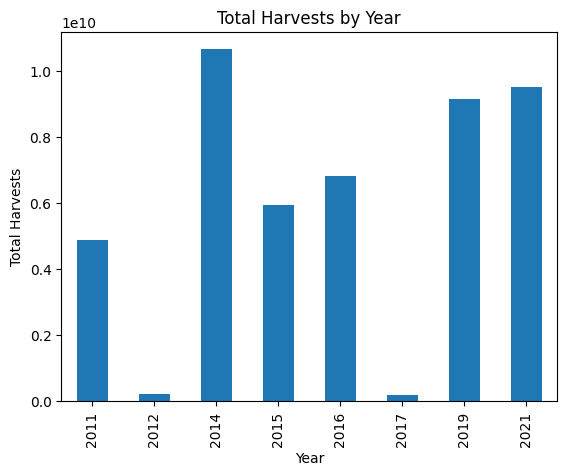

In [ ]:
yearly_harvests = crops_df.toPandas().groupby('Year')['total_harvested_sum'].sum()

# Create a bar chart of yearly harvests
yearly_harvests.plot(kind='bar')
plt.title('Total Harvests by Year')
plt.xlabel('Year')
plt.ylabel('Total Harvests')
plt.show()

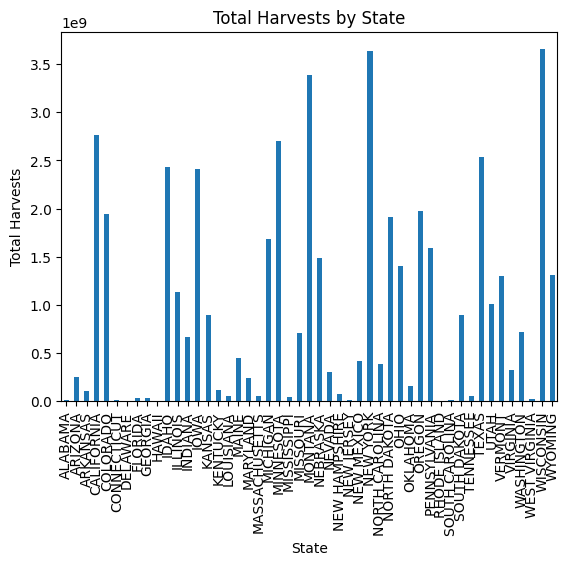

In [ ]:
state_harvests = crops_df.toPandas().groupby('State')['total_harvested_sum'].sum()

# Create a bar chart of state harvests
state_harvests.plot(kind='bar')
plt.title('Total Harvests by State')
plt.xlabel('State')
plt.ylabel('Total Harvests')
plt.show()

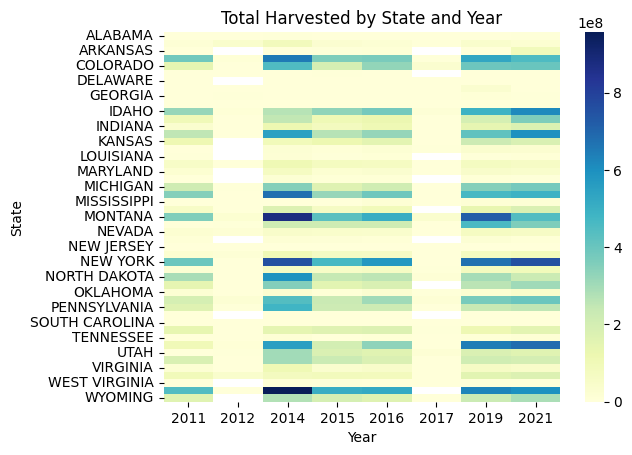

In [ ]:
# Pivot the data to create a matrix of total_harvested_sum by state and year
pivoted_df = crops_df.toPandas().pivot(index='State', columns='Year', values='total_harvested_sum')

# Create a heatmap of total_harvested_sum by state and year
sns.heatmap(pivoted_df, cmap='YlGnBu')
plt.xlabel('Year')
plt.ylabel('State')
plt.title('Total Harvested by State and Year')
plt.show()

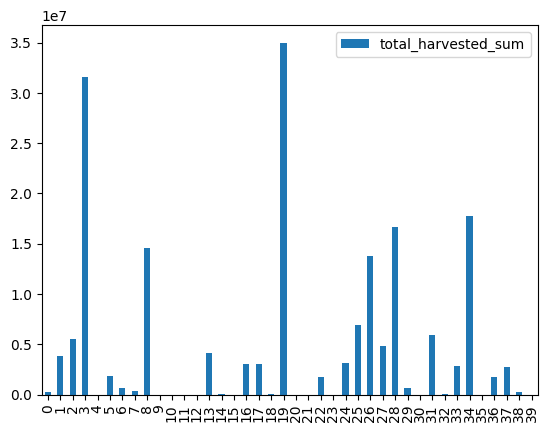

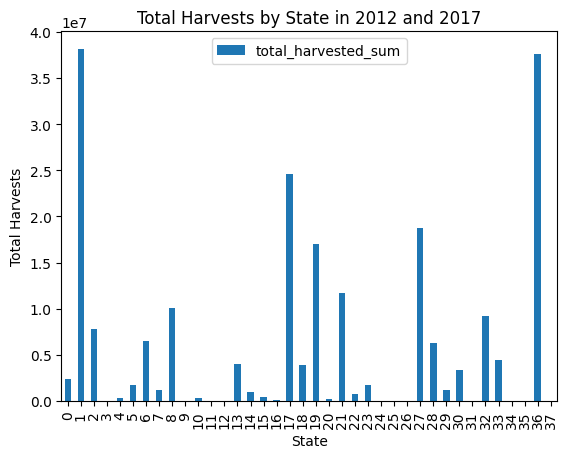

In [ ]:
# why the crop yield is so low in 2012 and 2017, not a lot of nulls but just low values, check the weather or soil quality
# make it into subplots
crops_2012 = crops_df.filter(crops_df.Year == 2012)
crops_2017 = crops_df.filter(crops_df.Year == 2017)
crops_2017.toPandas().plot(kind='bar', label='2017')
crops_2012.toPandas().plot(kind='bar', label='2012')
plt.title('Total Harvests by State in 2012 and 2017')
plt.xlabel('State')
plt.ylabel('Total Harvests')
plt.show()

# Weather in 2012 and 2017

In [11]:
print(weather_df.dtypes)

[('_c0', 'string'), ('_c1', 'int'), ('_c2', 'string'), ('_c3', 'int'), ('_c4', 'string'), ('_c5', 'string'), ('_c6', 'string'), ('_c7', 'int'), ('year', 'string')]


In [12]:
def to_day(weather_date: int) -> int:
    # should convert into sin and cos of the time to keep the cyclicity into the account
    weather_date = str(weather_date)
    date_np = np.array((weather_date[:4], weather_date[4:6], weather_date[6:8]), dtype=int)
    day_in_year = date(*date_np).timetuple().tm_yday

    return day_in_year
to_day_udf = udf(to_day, IntegerType())

In [13]:
weather_cleaned_df = weather_df.withColumn("_c1", to_day_udf("_c1"))

In [17]:
weather_cleaned_df.select(col("_c5"), col("_c7")).distinct().show()

+----+----+
| _c5| _c7|
+----+----+
|   K|null|
|null| 833|
|   I|1630|
|null|1645|
|null|2142|
|null|1959|
|null|1342|
|null|1829|
|null|2122|
|null| 148|
|   L|1920|
|null|1238|
|null| 623|
|null| 858|
|null| 737|
|null| 540|
|null|1127|
|null|1025|
|null|2235|
|null|1721|
+----+----+
only showing top 20 rows

